# Year 2023 Day 05


The the [Link Mark](https://observablehq.com/plot/marks/link) for the Observable Plot visualization library is used here.

Initially, I planned to use a Sankey diagram, but it turned out drawing literal links manually was easier.

The objective of the visualization will be the following: visualize the mapping of source to target ranges. Horizontally, on the x-axis, will be represented the identifier number, while vertically, on the y-axis, the successive categories will be shown, from top to bottom.

To reverse the y-axis, the [`reverse=True`](https://observablehq.com/plot/features/scales) option is used.

y = [seed, soil..., humidity] = [0, 1, ...] with 
x = constant for all filter = input range

The reference visualization kept in mind in this notebook is the following: [\[2023 Day 5 Part 2\] Visualizing all the mapping ](https://www.reddit.com/r/adventofcode/comments/18b82w0/2023_day_5_part_2_visualizing_all_the_mapping/). The visualization in this notebook will be simpler, as no surface will be drawn like in this reference, but rather, a central line indicating the direction of the mapping, in red, with its left and right boundaries shown in white.


In [1]:
import json
from typing import Literal

import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import Markdown as md
from pyobsplot import Obsplot, Plot

from advent_of_code.common.common import get_example_inputs_file_contents
from advent_of_code.visualization.plotly import (
    ValuedLink,
    build_sankey_figure,
    to_plotly_sankey_input,
)
from advent_of_code.y_2023.problem_202305 import AdventOfCodeProblem202305, Almanac

In [2]:
op = Obsplot(renderer="jsdom", theme="dark")  # Literal['current','light','dark']

In [3]:
problem = AdventOfCodeProblem202305()
problem

AdventOfCodeProblem202305(year=2023, day=5)

In [4]:
# test_input = example_inputs_2023.retrieve(__file__)
# almanac = parse_almanac(test_input)

example_input = get_example_inputs_file_contents(2023)["test_problem_202305"][
    "EXAMPLE_INPUT"
]

## With Example Input


In [5]:
almanac = problem.parse_text_input(example_input)

In [6]:
almanac

Almanac(seeds=[79, 14, 55, 13], maps=[AlmanacMap(source_category='seed', destination_category='soil', ranges=[AlmanacRange(destination_range_start=50, source_range_start=98, range_length=2), AlmanacRange(destination_range_start=52, source_range_start=50, range_length=48)]), AlmanacMap(source_category='soil', destination_category='fertilizer', ranges=[AlmanacRange(destination_range_start=0, source_range_start=15, range_length=37), AlmanacRange(destination_range_start=37, source_range_start=52, range_length=2), AlmanacRange(destination_range_start=39, source_range_start=0, range_length=15)]), AlmanacMap(source_category='fertilizer', destination_category='water', ranges=[AlmanacRange(destination_range_start=49, source_range_start=53, range_length=8), AlmanacRange(destination_range_start=0, source_range_start=11, range_length=42), AlmanacRange(destination_range_start=42, source_range_start=0, range_length=7), AlmanacRange(destination_range_start=57, source_range_start=7, range_length=4)]),

In [7]:
almanac.maps

[AlmanacMap(source_category='seed', destination_category='soil', ranges=[AlmanacRange(destination_range_start=50, source_range_start=98, range_length=2), AlmanacRange(destination_range_start=52, source_range_start=50, range_length=48)]),
 AlmanacMap(source_category='soil', destination_category='fertilizer', ranges=[AlmanacRange(destination_range_start=0, source_range_start=15, range_length=37), AlmanacRange(destination_range_start=37, source_range_start=52, range_length=2), AlmanacRange(destination_range_start=39, source_range_start=0, range_length=15)]),
 AlmanacMap(source_category='fertilizer', destination_category='water', ranges=[AlmanacRange(destination_range_start=49, source_range_start=53, range_length=8), AlmanacRange(destination_range_start=0, source_range_start=11, range_length=42), AlmanacRange(destination_range_start=42, source_range_start=0, range_length=7), AlmanacRange(destination_range_start=57, source_range_start=7, range_length=4)]),
 AlmanacMap(source_category='water

In [8]:
categories = [am.source_category for am in almanac.maps] + [
    almanac.maps[-1].destination_category
]
categories

['seed',
 'soil',
 'fertilizer',
 'water',
 'light',
 'temperature',
 'humidity',
 'location']

Create the couples of lines materializing the left and right boundaries of the mapping. They will be displayed in white.

In [9]:
def create_lines_df(
    almanac: Almanac, *, mode: Literal["single", "couple"]
) -> pd.DataFrame:
    lines = []

    for idx, am in enumerate(almanac.maps):
        for r in am.ranges:
            x1_start = r.source_range_start
            x2_start = r.destination_range_start
            x1_end = x1_start + r.range_length
            x2_end = x2_start + r.range_length
            y1 = idx
            y2 = idx + 1

            use_category_names = True
            if use_category_names:
                y1 = categories[y1]
                y2 = categories[y2]

            if mode == "single":
                singles = ((x1_start, x2_start),)

                do_center = True
                for x1, x2 in singles:
                    if do_center:
                        lines.append(
                            (
                                x1 + r.range_length / 2,
                                y1,
                                x2 + r.range_length / 2,
                                y2,
                                r.range_length,
                            )
                        )
                    else:
                        lines.append((x1, y1, x2, y2, r.range_length))
            elif mode == "couple":
                couples = (x1_start, x2_start), (x1_end, x2_end)
                for x1, x2 in couples:
                    lines.append((x1, y1, x2, y2, r.range_length))
            else:
                raise NotImplementedError

    lines_df = pd.DataFrame(lines, columns=["x1", "y1", "x2", "y2", "range_length"])
    return lines_df


lines_df = create_lines_df(almanac, mode="couple")
lines_df[:4]
lines_df

,x1,y1,x2,y2,range_length
0,98,seed,50,soil,2
1,100,seed,52,soil,2
2,50,seed,52,soil,48
3,98,seed,100,soil,48
4,15,soil,0,fertilizer,37
5,52,soil,37,fertilizer,37
6,52,soil,37,fertilizer,2
7,54,soil,39,fertilizer,2
8,0,soil,39,fertilizer,15
9,15,soil,54,fertilizer,15


Create the single central lines materializing the center of the mapping. They will be displayed in red.

In [10]:
centered_lines_df = create_lines_df(almanac, mode="single")
centered_lines_df

,x1,y1,x2,y2,range_length
0,99.0,seed,51.0,soil,2
1,74.0,seed,76.0,soil,48
2,33.5,soil,18.5,fertilizer,37
3,53.0,soil,38.0,fertilizer,2
4,7.5,soil,46.5,fertilizer,15
5,57.0,fertilizer,53.0,water,8
6,32.0,fertilizer,21.0,water,42
7,3.5,fertilizer,45.5,water,7
8,9.0,fertilizer,59.0,water,4
9,21.5,water,91.5,light,7


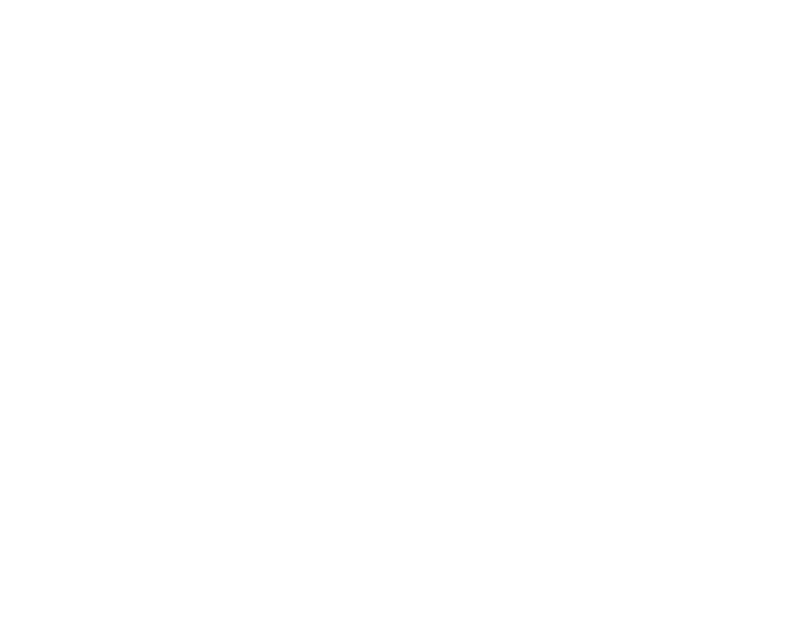

In [11]:
def show_links(
    lines_df: pd.DataFrame,
    centered_lines_df: pd.DataFrame,
    *,
    marginLeft=100,
    marginRight=50,
    width=640,
    height=640,
):
    # lines_df : DataFrame with columns x1	y1	x2	y2
    return op(  # type: ignore
        dict(
            grid=True,
            width=width + marginLeft + marginRight,
            height = height,
            marginLeft=marginLeft,  # make room for the y-axis
            marginRight=marginRight,
            x=dict(label="Identifier number", tickFormat=".0s", ticks=10, nice=True),
            y=dict(
                label="Category",
                domain=categories,
                type="band",
                padding=0,
            ),
            marks=[
                Plot.ruleY(
                    categories, dict(stroke="white", strokeOpacity=1, strokeWidth=1)
                ),
                Plot.link(
                    lines_df,
                    dict(
                        x1=lines_df["x1"].to_list(),
                        y1=lines_df["y1"].to_list(),
                        x2=lines_df["x2"].to_list(),
                        y2=lines_df["y2"].to_list(),
                        # markerEnd="arrow",
                        stroke="currentColor",
                        strokeOpacity=0.4,
                        curve="bump-y",
                        strokeWidth=2,
                    ),
                ),
                Plot.link(
                    centered_lines_df,
                    dict(
                        x1=centered_lines_df["x1"].to_list(),
                        y1=centered_lines_df["y1"].to_list(),
                        x2=centered_lines_df["x2"].to_list(),
                        y2=centered_lines_df["y2"].to_list(),
                        # markerEnd="arrow",
                        strokeOpacity=1,
                        stroke="red",
                        curve="bump-y",
                        strokeWidth=2,
                    ),
                ),
            ],
        )
    )


show_links(lines_df, centered_lines_df)

## With Actual Input


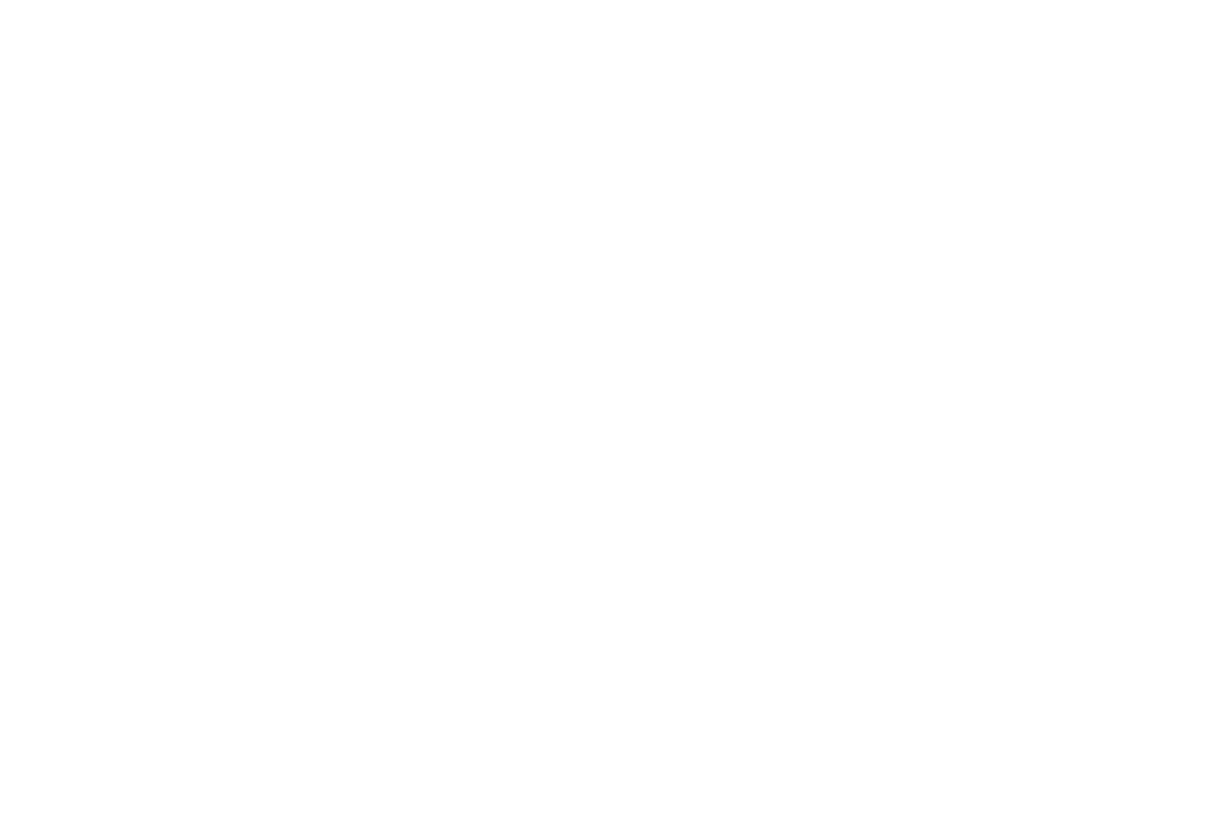

In [12]:
actual_input = problem.parse_input_text_file()
show_links(
    create_lines_df(actual_input, mode="couple"),
    create_lines_df(actual_input, mode="single"),
    width=1080, height= 840,
)